# 02. Neural Network Classification with PyTorch

## TK - What we're going to cover

* Simple classification (reiterate PyTorch workflow)
* More advanced classification (e.g. black and white images or FashionMNIST or FoodMNIST or something)
* Visualizing a PyTorch model (all of the different connections)

## TK - How you can use this notebook

## TK - Architecture of a classification network

## TK - Make data

In [116]:
from sklearn.datasets import make_moons

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_moons(n_samples,
                  noise=0.07,
                  random_state=42) # keep random state so we get the same values

In [117]:
# Get dataframe of moons
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head()

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


In [118]:
# Check different labels
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

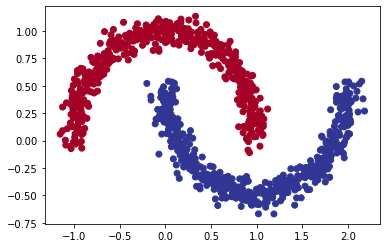

In [119]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

TK - why show data like this? This is a toy problem but it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify (separate red from blue) it.

## TK - Input and output shapes

In [5]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

In [7]:
# View the first example of features and labels
X[0], y[0]

(array([-0.03341062,  0.4213911 ]), 1)

In [ ]:
# TODO: Turn data into tensors
# Otherwise this causes issues with computations later on

## TK - Steps in modelling

1. Construct the model
2. Setup loss and optimizer
3. Create training/eval loop

### TK - Building a model 

In [60]:
import torch
from torch import nn
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # TK - explain in and out features (could use TF playground for this)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = MoonModelV0()
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

In [89]:
# TODO, show case the same model with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

### TK - Setup loss and optimizer

In [61]:
# TK - Explain both of these - https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = Sigmoid built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [62]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### TK - Train model

In [64]:
# TK - clean this up for different data types (could be far clearer what's going on)

epochs = 100
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_0(torch.as_tensor(X).type(torch.float)) # this won't work unless X & y are tensors
    # print(y_pred)
    # print(torch.round(torch.sigmoid(y_pred)))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred.squeeze(), torch.as_tensor(y).type(torch.float))
    acc = accuracy_fn(y_true=torch.as_tensor(y).type(torch.float), 
                      y_pred=torch.round(torch.sigmoid(y_pred)).squeeze())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")

Epoch: 0 | Loss: 0.7493689656257629, Accuracy: 49.3
Epoch: 10 | Loss: 0.530167281627655, Accuracy: 81.39999999999999
Epoch: 20 | Loss: 0.43907541036605835, Accuracy: 80.7
Epoch: 30 | Loss: 0.3934064507484436, Accuracy: 80.9
Epoch: 40 | Loss: 0.36696216464042664, Accuracy: 81.2
Epoch: 50 | Loss: 0.3494340777397156, Accuracy: 81.3
Epoch: 60 | Loss: 0.33643555641174316, Accuracy: 82.39999999999999
Epoch: 70 | Loss: 0.32597506046295166, Accuracy: 82.89999999999999
Epoch: 80 | Loss: 0.3170924484729767, Accuracy: 83.39999999999999
Epoch: 90 | Loss: 0.30929964780807495, Accuracy: 83.6


## TK - Plot model predictions

In [ ]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [82]:
import numpy as np
def plot_multiclass_decision_boundary(model, X, y):
    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = torch.round(torch.sigmoid(model(torch.as_tensor(X_test).type(torch.float))))
    # _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

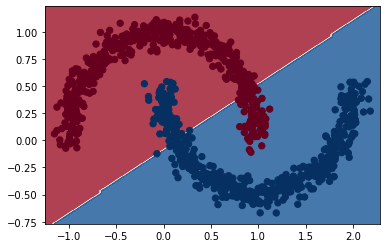

In [83]:
plot_multiclass_decision_boundary(model_0, X, y)

## TK - Improving a model

TODO
* Add layers 
* Add units
* Train for longer...


In [134]:
class MoonModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=50)
        self.layer_3 = nn.Linear(in_features=50, out_features=1)
        
    def forward(self, x): # always make sure forward is spelt correctly!
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = MoonModelV1()
model_1

MoonModelV1(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=1, bias=True)
)

In [135]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [136]:
epochs = 1000
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_1(torch.as_tensor(X).type(torch.float))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred.squeeze(), torch.as_tensor(y).type(torch.float))
    # loss = loss_fn(torch.sigmoid(y_pred).squeeze(), torch.as_tensor(y).type(torch.float))
    acc = accuracy_fn(y_true=torch.as_tensor(y).type(torch.float), 
                      y_pred=torch.round(torch.sigmoid(y_pred)).squeeze())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print outputs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")


Epoch: 0 | Loss: 0.6875528693199158, Accuracy: 58.8
Epoch: 100 | Loss: 0.24515405297279358, Accuracy: 88.6
Epoch: 200 | Loss: 0.24449464678764343, Accuracy: 88.6
Epoch: 300 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 400 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 500 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 600 | Loss: 0.24449162185192108, Accuracy: 88.6
Epoch: 700 | Loss: 0.24449162185192108, Accuracy: 88.6
Epoch: 800 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 900 | Loss: 0.2444916069507599, Accuracy: 88.6


## Multi-class model 

### Data

PyTorch FashionMNIST - https://pytorch.org/vision/stable/datasets.html

### Model

TODO
* Make multi-class model
* Visualize the model

### Evaluate

## TODO
* Multiclass model
* GPU model
* Fixed data inputs (e.g. calc on tensors when need to calc on tensors)
* Merge the functions so `plot_decision_boundary` works on multi-class
* Introduce non-linearity (the missing piece!) - straight lines and non-straight lines